# [IAPR][iapr]: Final project - Chocolate Recognition


**Moodle group ID:** 50  
**Kaggle challenge:** Classic (either `Classic` or `Deep learning`)  
**Kaggle team name (exact):** "*xx*"  

**Author 1 (SCIPER):** *Louis Cuicui (xxxxxx)*  
**Author 2 (SCIPER):** *Timur Ünver (xxxxx)*  
**Author 3 (SCIPER):** *Adrien Boschung (327221)*  

**Due date:** 21.05.2025 (11:59 pm)


## Key Submission Guidelines:
- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`
- **Only groups of three will be accepted**, except in exceptional circumstances.


[iapr]: https://github.com/LTS5/iapr2025

---

> Your comments  
> ...

In [1]:
# IMPORTS FROM LABS #
import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from skimage.color import rgb2hsv
from skimage.morphology import closing, opening, disk, remove_small_holes, remove_small_objects, binary_dilation
from skimage.transform import rotate, resize, warp
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours

import cv2 # are we allowed?
import numpy as np

import platform
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from typing import Optional, Callable
from sklearn.metrics import accuracy_score, f1_score
from sklearn.covariance import LedoitWolf
import torch.optim as optim

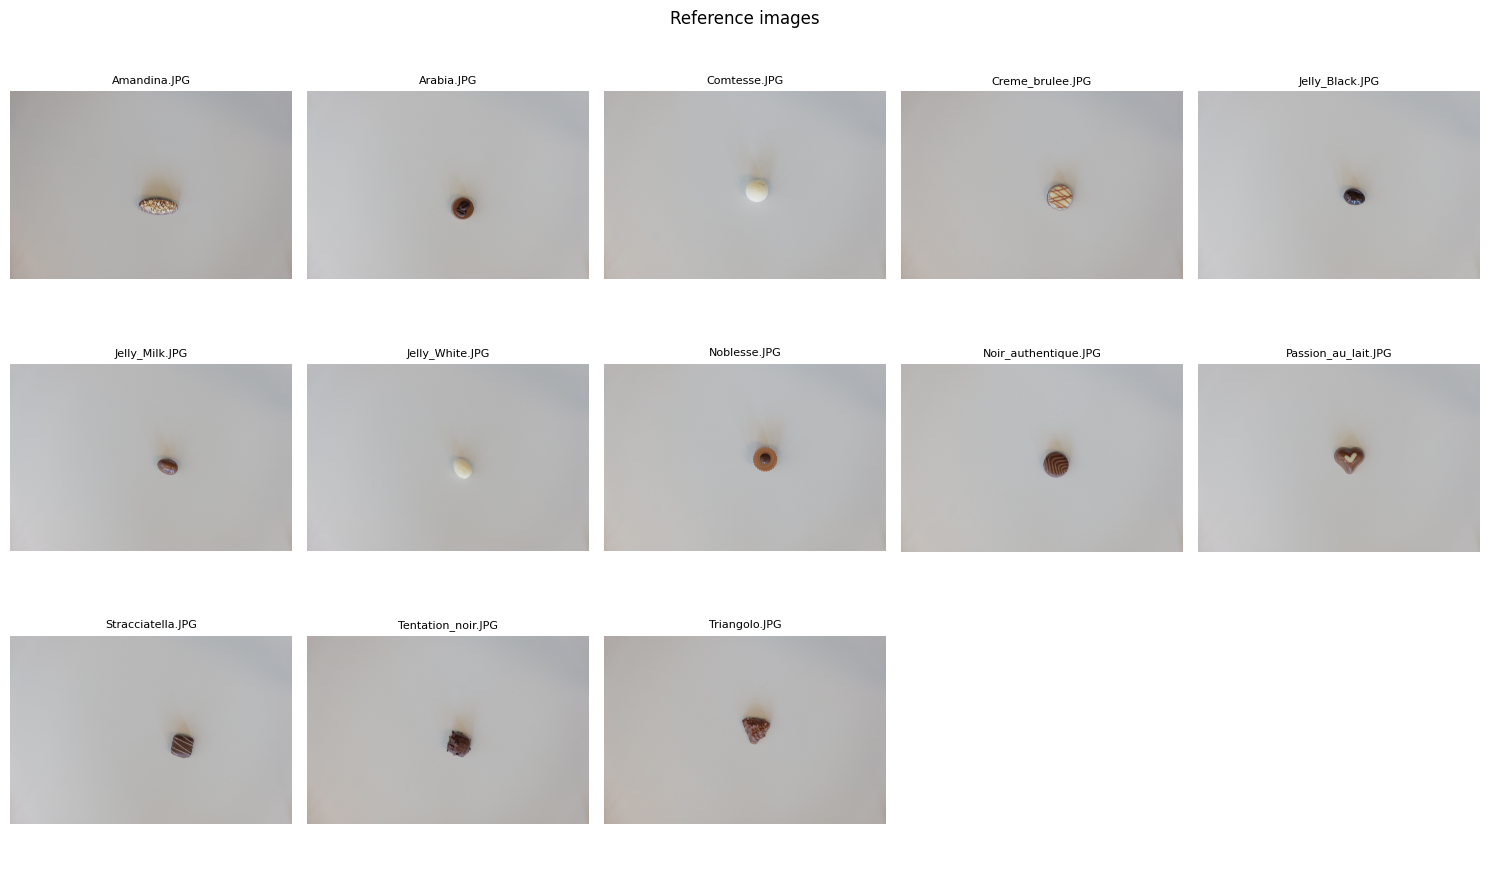

In [304]:
path_ref = '../project/dataset_project_iapr2025/references'

jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

cols = 5
rows = (n_images + cols - 1) // cols 
fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

plt.suptitle('Reference images')

for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(jpg_files[i], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

# Pipeline
* Detect the chocolates edges and shape (and other features)
* Isolate the chocolates from each image 
* Match the chocolates with reference (translation/rotation invariance, scaling not needed) through shape, patterns, colors. A decision tree might be useful. For example, we have four different shapes (Square, Triangle, Circular, Oval). We also have different colors (White, Brown, Dark Brown/Black). Finally some of the chocolates have different patterns (strides, ...).

A problem would be to differentiate other items from chocolate and to predict the number of chocolates per image. A maximum would be to estimate the largest number of chocolates we could have and then set it as the number of chocolates we are looking for. Then when comparing the shapes of the items, we can consider the shapes that do not fit any of the shapes as OoD.

Here, I will try to isolate the chocolate from each of the reference chocolates. Each chocolate needs personnalized tuning due to differences in colors (main reason).

In [305]:
chocolates = []

#### Dark chocolates

In [306]:
# Transform the image to an array and make it binary
# This holds for dark color chocolates 1,4,5,7,8,9,10,11,12
img_path = os.path.join(path_ref, jpg_files[12])
img = Image.open(img_path).convert('L')
#plt.figure()
#plt.imshow(img)
img = np.array(img)
img = img < 135
#plt.figure()
#plt.imshow(img)

In [307]:
# Get the shape through morphology operations
footprint = disk(10)
img = closing(img, footprint)
img = remove_small_holes(img, 10000)
#plt.imshow(img)

In [308]:
# Isolate the chocolate part of the original image
mask = img.copy() #np.all(img > 1, axis=2)
img_path = os.path.join(path_ref, jpg_files[12])
img_ref = mpimg.imread(img_path)
masked_img = np.zeros_like(img_ref)
masked_img[mask] = img_ref[mask]
#plt.figure()
#plt.imshow(masked_img)

# Crop it
coords = np.argwhere(mask) 
y0, x0 = coords.min(axis=0)
y1, x1 = coords.max(axis=0) + 1  # +1 because slicing is exclusive
cropped_img = masked_img[y0:y1, x0:x1]
#plt.figure()
#plt.imshow(cropped_img)

#### Light colored chocolates

" plt.figure()\nplt.imshow(img, cmap='gray')\nfor contour in contours:\n    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')  # note: column=x, row=y\nplt.title('Contours on Binary Image')\nplt.axis('off')\nplt.show() "

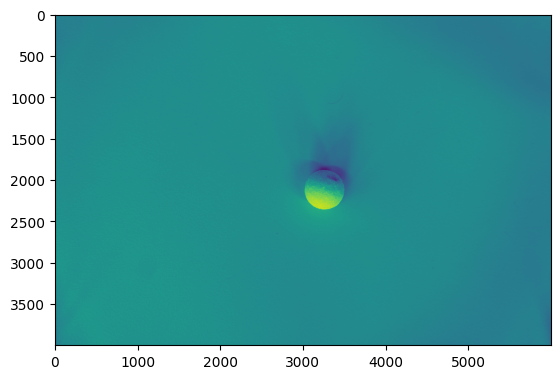

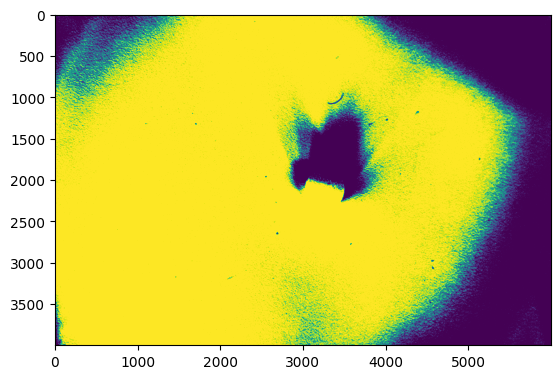

In [309]:
# Transform the image to an array and make it binary
# This holds for dark color chocolates 1,4,5,7,8,9,10,11,12
img_path = os.path.join(path_ref, jpg_files[2])
img = Image.open(img_path).convert('L')
plt.imshow(img)
img = np.array(img)
img_light = 255 - (img < 200)
img_dark = (img < 170) & (img > 150)
img = img_dark+img_light
plt.figure()
plt.imshow(img)
#contours = find_contours(img)
#print(len(contours))
# Display image with contours
""" plt.figure()
plt.imshow(img, cmap='gray')
for contour in contours:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')  # note: column=x, row=y
plt.title('Contours on Binary Image')
plt.axis('off')
plt.show() """

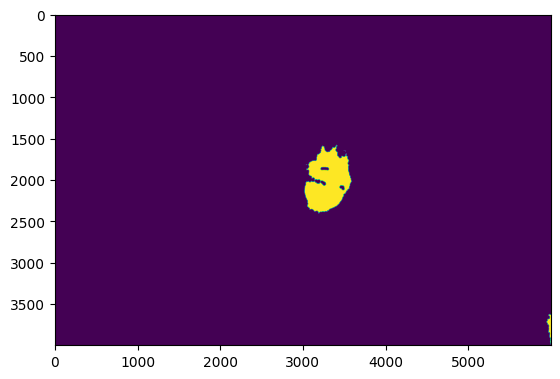

In [310]:
# Get the shape through morphology operations
footprint = disk(15)
img = closing(img, footprint)
#img = remove_small_holes(img, 10000)
plt.imshow(img)

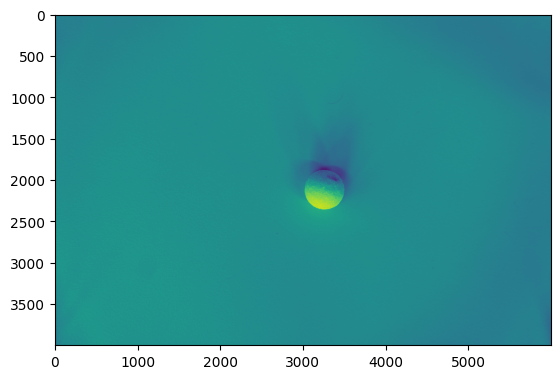

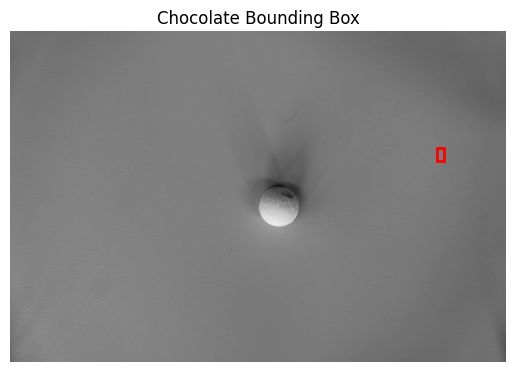

In [311]:
from skimage.measure import label, regionprops

img_path = os.path.join(path_ref, jpg_files[2])
img = Image.open(img_path).convert('L')
plt.imshow(img)
img = np.array(img)

labeled = label(img)
props = regionprops(labeled)

# Largest region = chocolate
if props:
    chocolate = max(props, key=lambda x: x.area)
    minr, minc, maxr, maxc = chocolate.bbox

    # Draw bounding box
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
                         edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(rect)
    plt.title('Chocolate Bounding Box')
    plt.axis('off')
    plt.show()

In [312]:
def extract_hsv_channels(img):
    """
    Extract HSV channels from the input image.

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    
    Return
    ------
    data_h: np.ndarray (M, N)
        Hue channel of input image
    data_s: np.ndarray (M, N)
        Saturation channel of input image
    data_v: np.ndarray (M, N)
        Value channel of input image
    """

    # Get the shape of the input image
    M, N, C = np.shape(img)

    # Define default values for HSV channels
    data_h = np.zeros((M, N))
    data_s = np.zeros((M, N))
    data_v = np.zeros((M, N))

    # ------------------
    img_hsv = rgb2hsv(img)
    data_h = img_hsv[:, :, 0]
    data_s = img_hsv[:, :, 1]
    data_v = img_hsv[:, :, 2]
    # ------------------
    
    return data_h, data_s, data_v

In [313]:
def plot_colors_histo(
    img: np.ndarray,
    func: Callable,
    labels: list[str],
):
    """
    Plot the original image (top) as well as the channel's color distributions (bottom).

    Args
    ----
    img: np.ndarray (M, N, C)
        Input image of shape MxN and C channels.
    func: Callable
        A callable function that extracts D channels from the input image
    labels: list of str
        List of D labels indicating the name of the channel
    """

    # Extract colors
    channels = func(img=img)
    C2 = len(channels)
    M, N, C1 = img.shape
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, C2)

    # Use random seed to downsample image colors (increase run speed - 10%)
    mask = np.random.RandomState(seed=0).rand(M, N) < 0.1
    
    # Plot base image
    ax = fig.add_subplot(gs[:2, :])
    ax.imshow(img)
    # Remove axis
    ax.axis('off')
    ax1 = fig.add_subplot(gs[2, 0])
    ax2 = fig.add_subplot(gs[2, 1])
    ax3 = fig.add_subplot(gs[2, 2])

    # Plot channel distributions
    ax1.scatter(channels[0][mask].flatten(), channels[1][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.set_title("{} vs {}".format(labels[0], labels[1]))
    ax2.scatter(channels[0][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax2.set_xlabel(labels[0])
    ax2.set_ylabel(labels[2])
    ax2.set_title("{} vs {}".format(labels[0], labels[2]))
    ax3.scatter(channels[1][mask].flatten(), channels[2][mask].flatten(), c=img[mask]/255, s=1, alpha=0.1)
    ax3.set_xlabel(labels[1])
    ax3.set_ylabel(labels[2])
    ax3.set_title("{} vs {}".format(labels[1], labels[2]))
        
    plt.tight_layout()


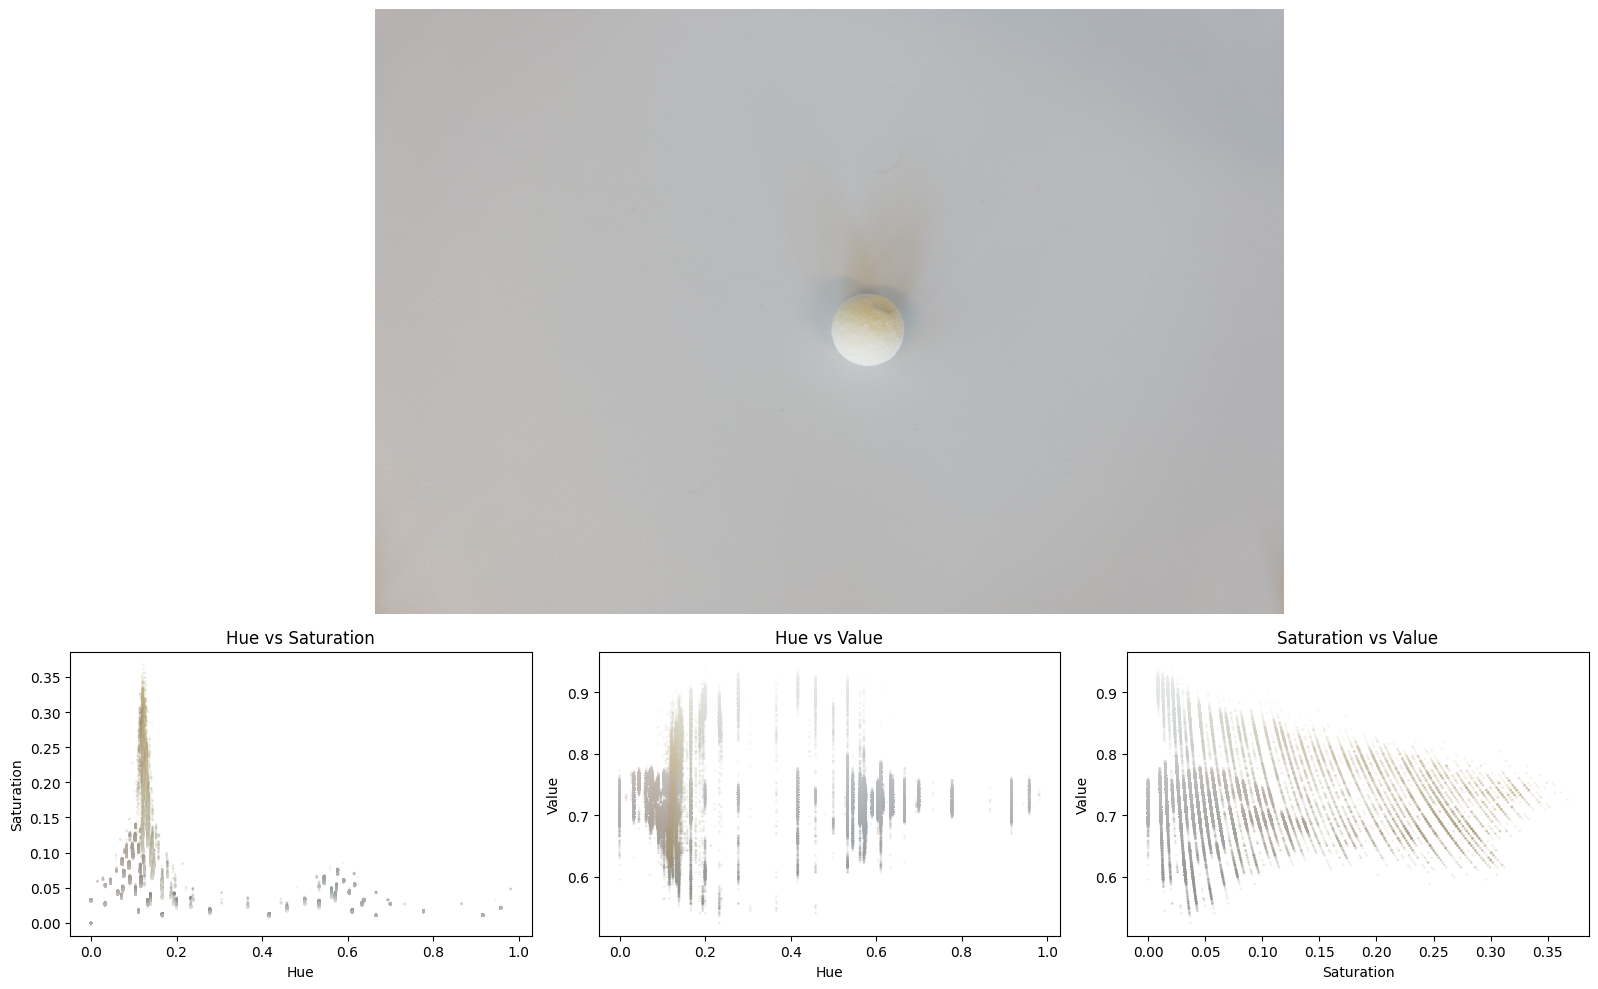

In [314]:
img = np.array(Image.open(img_path))
plot_colors_histo(
    img = img,
    func = extract_hsv_channels,
    labels = ["Hue", "Saturation", "Value"],
)

#### Get all chocolates pattern

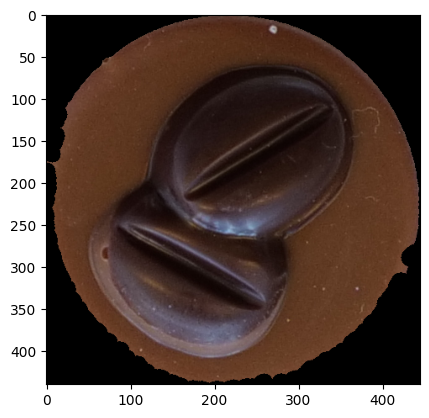

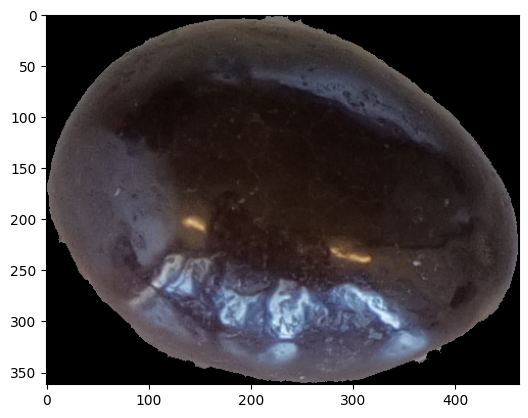

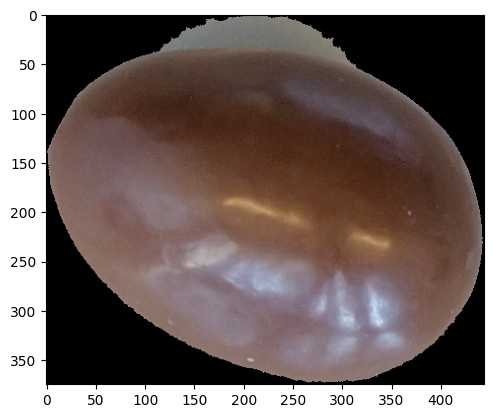

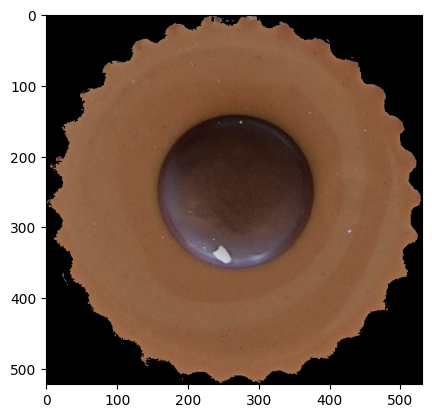

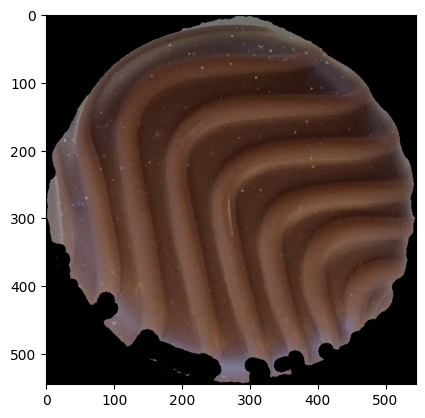

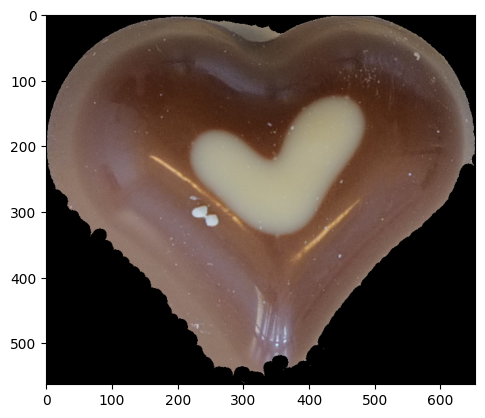

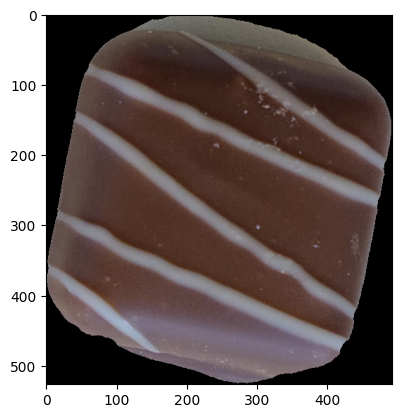

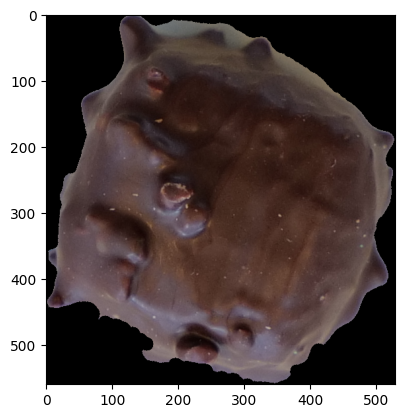

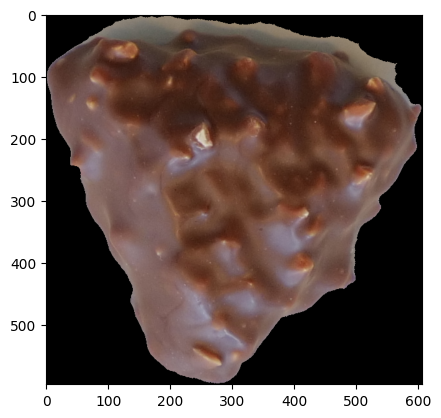

In [315]:
patterns = []
for i in range(len(jpg_files)):
    if i in [0,2,3,6] :
        continue
    
    # Transform the image to an array and make it binary
    img_path = os.path.join(path_ref, jpg_files[i])
    img = Image.open(img_path).convert('L')

    binary_threshold=0
    fp=disk(0)
    nb_holes=0

    # Specific setup for different chocolates
    # Dark/Brown chocolates
    if i == 0 : # Armandina --> to be improved
        binary_threshold = 135
        fp = disk(30)
        nb_holes = 20000

    if i == 1 : # Arabia
        binary_threshold = 80
        fp = disk(10)
        nb_holes = 10000

    if i == 4 : # Jelly Black
        binary_threshold = 110
        fp = disk(5)
        nb_holes = 10000
    
    if i == 5 : # Jelly Milk
        binary_threshold = 130
        fp = disk(5)
        nb_holes = 10000
    
    if i == 7 : # Noblesse
        binary_threshold = 125
        fp = disk(0)
        nb_holes = 10000

    if i == 8 : # Noir Authentique --> to be improved
        binary_threshold = 115
        fp = disk(10)
        nb_holes = 10000

    if i == 9 : # Passion au lait --> to be improved
        binary_threshold = 125
        fp = disk(10)
        nb_holes = 30000

    if i == 10 : # Straciatella --> to be improved
        binary_threshold = 120
        fp = disk(20)
        nb_holes = 10000

    if i == 11 : # Tentation noir --> to be improved
        binary_threshold = 115
        fp = disk(10)
        nb_holes = 10000
    
    if i == 12 : # Triangolo --> to be improved
        binary_threshold = 135
        fp = disk(10)
        nb_holes = 10000

    # Morphology operations
    img = np.array(img)
    img = img < binary_threshold
    footprint = fp
    img = closing(img, footprint)
    img = remove_small_holes(img, nb_holes)

    # Isolate the chocolate part of the original image
    img_ref = mpimg.imread(img_path)
    mask = img.copy()
    masked_img = np.zeros_like(img_ref)
    masked_img[img] = img_ref[img]

    # Crop it
    coords = np.argwhere(mask) 
    y0, x0 = coords.min(axis=0) - 1
    y1, x1 = coords.max(axis=0) + 2  # +1 because slicing is exclusive
    cropped_img = masked_img[y0:y1, x0:x1]
    plt.figure()
    plt.imshow(cropped_img)
    patterns.append(cropped_img)

### Fourier descriptors of reference images

Here we will extract Fourier descriptors of reference images. This will allow us to compare them to the chocolates we extract from the images and classify the them according to their shape. First we need to get the contours of the reference images:

In [333]:
# Contours
contours_patterns = []

def contour_of_patterns(patterns):
    contours_patterns = []
    for i in range(len(patterns)):
        if i < n_images:
            plt.figure()
            img = patterns[i]
            img = np.array(img)
            img = np.mean(img, axis=2)
            binary = img > 0 
            contours = find_contours(binary, level=0.5)
            if contours:
                contour = np.fliplr(max(contours, key=lambda x: x.shape[0]))
                contours_patterns.append(contour)
                plt.imshow(patterns[i], cmap='gray')
                plt.axis('off')
                plt.plot(contour[:, 0], contour[:, 1], linewidth=2, color='red')  # use [:, 0] and [:, 1]
        else:
            ax.axis('off')  # Hide empty subplots

    return contours_patterns


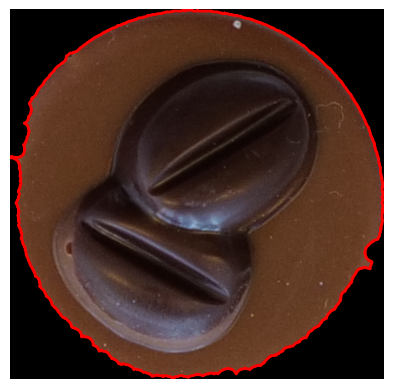

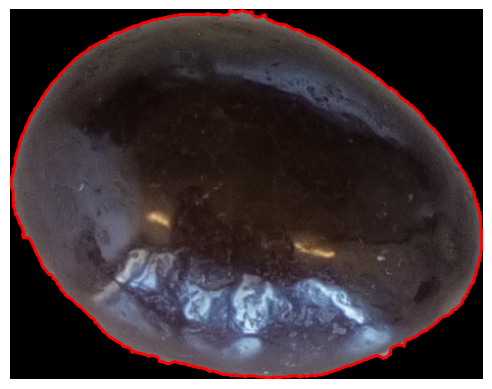

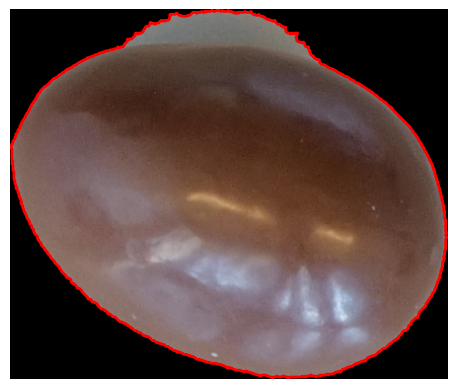

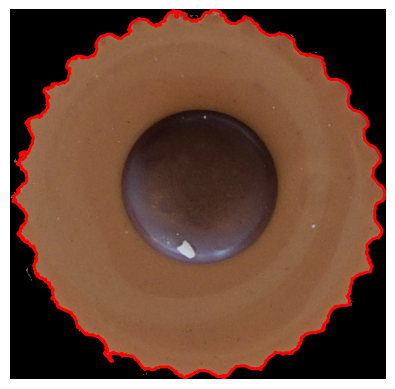

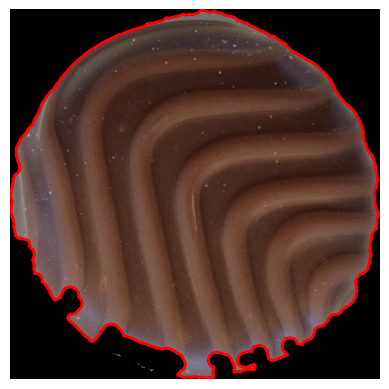

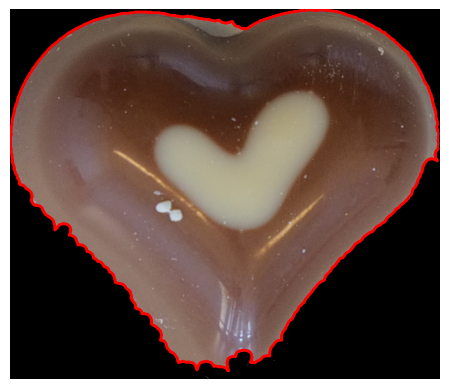

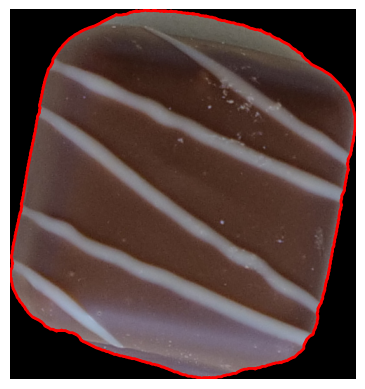

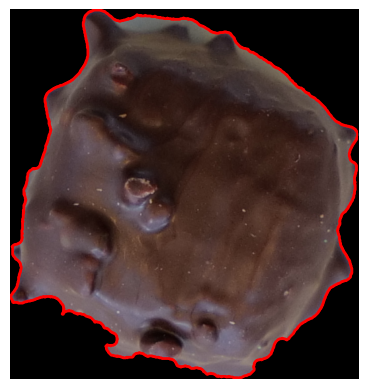

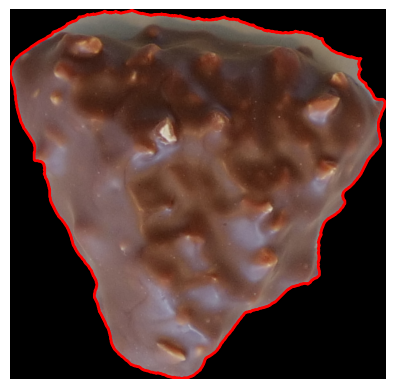

In [334]:
contours_patterns = contour_of_patterns(patterns)

Now that the contours are defined we can compute the Fourier descriptors:

In [335]:
def compute_descriptor_padding(contours: np.ndarray, n_samples: int = 11):
    """
    Compute Fourier descriptors of input images
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider. If the contour length is higher, discard the remaining part. If it is shorter, add padding.
        Make sure that the first element of the descriptor represents the continuous component.

    Return
    ------
    descriptors: np.ndarray complex (N, n_samples)
        Computed complex Fourier descriptors for the given input images
    """

    N = len(contours)
    # Look for the number of contours
    descriptors = np.zeros((N, n_samples), dtype=np.complex128)

    # ------------------
    for i in range(N):
        contour = contours[i]
        if len(contour) > n_samples:
            contour = contour[:n_samples]
        elif len(contour) < n_samples:
            contour = np.concatenate((contour, np.zeros((n_samples - len(contour), 2))), axis=0)
        descriptors[i, :] = np.fft.fft(contour[:, 0] + 1j * contour[:, 1], n_samples, axis=0)
    # ------------------

    return descriptors

def linear_interpolation(contours: np.ndarray, n_samples: int = 11):
    """
    Perform interpolation/resampling of the contour across n_samples.
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contours_inter: np.ndarray (N, n_samples, 2)
        Interpolated contour with n_samples
    """

    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    # ------------------
    for i in range(N):
        # Get the contour to process
        contour = contours[i]
        # Compute the distance between points
        dist = np.sqrt(np.sum(np.diff(contour, axis=0) ** 2, axis=1))
        # Compute the cumulative distance
        cum_dist = np.concatenate(([0], np.cumsum(dist))) #with initial point at 0
        # Interpolate the points
        dist = np.linspace(0, cum_dist[-1], n_samples) #defining the distance axis (from 0 to the total distance at [-1] index)
        x_interp = np.interp(dist, cum_dist, contour[:, 0]) #x as a function of distance
        y_interp = np.interp(dist, cum_dist, contour[:, 1]) #y as a function of distance
        contours_inter[i] = np.array([x_interp, 
                                      y_interp]).T #transposing to get the right shape
    # ------------------
        
    return contours_inter


### Invariance

We probably dont want scaling invariance as all the size of chocolates is constant accross the dataset.

In [336]:
def translation_invariant(features):
    """
    Make input Fourier descriptors invariant to translation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to translation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    features_inv[:,1:] = features[:,1:]
    # ------------------
    
    return features_inv

In [337]:
def rotation_invariant(features):
    """
    Make input Fourier descriptors invariant to rotation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to rotation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    features_inv = np.abs(features)
    # ------------------
    
    return features_inv

Compute Fourier descriptors for the different possible shapes:

In [338]:
contours_patterns = linear_interpolation(contours_patterns, n_samples = 150)
descriptors = translation_invariant(rotation_invariant(compute_descriptor_padding(contours_patterns)))
print(descriptors.shape)
# Visualize Fourier descriptors
""" for i, des in enumerate(descriptors):
    plt.figure(figsize=(12, 6))

    # Plot the magnitude of the Fourier descriptors
    plt.subplot(1, 2, 1)
    plt.plot(np.abs(des), marker='o')
    plt.title(f"Fourier Descriptor Magnitude (Pattern {i})")
    plt.xlabel("Frequency Index")
    plt.ylabel("Magnitude")
    plt.grid()

    # Plot the phase of the Fourier descriptors
    plt.subplot(1, 2, 2)
    plt.plot(np.angle(des), marker='o')
    plt.title(f"Fourier Descriptor Phase (Pattern {i})")
    plt.xlabel("Frequency Index")
    plt.ylabel("Phase (radians)")
    plt.grid()

    plt.tight_layout()
    plt.show() """

(9, 11)


' for i, des in enumerate(descriptors):\n    plt.figure(figsize=(12, 6))\n\n    # Plot the magnitude of the Fourier descriptors\n    plt.subplot(1, 2, 1)\n    plt.plot(np.abs(des), marker=\'o\')\n    plt.title(f"Fourier Descriptor Magnitude (Pattern {i})")\n    plt.xlabel("Frequency Index")\n    plt.ylabel("Magnitude")\n    plt.grid()\n\n    # Plot the phase of the Fourier descriptors\n    plt.subplot(1, 2, 2)\n    plt.plot(np.angle(des), marker=\'o\')\n    plt.title(f"Fourier Descriptor Phase (Pattern {i})")\n    plt.xlabel("Frequency Index")\n    plt.ylabel("Phase (radians)")\n    plt.grid()\n\n    plt.tight_layout()\n    plt.show() '

In [339]:
def normalize_descriptors(descriptors):
    normalized = []
    for des in descriptors:
        # Remove the DC component (translation invariance)
        des[0] = 0
        # Scale invariance
        des = des / np.abs(des[1])
        # Use only magnitudes (rotation invariance)
        normalized.append(np.abs(des))
    return np.array(normalized)

normalized_descriptors = normalize_descriptors(descriptors)

In [340]:
correct_labels = [0,1,1,0,0,2,3,3,2]
print(correct_labels)
# 0 = Circle
# 1 = Oval
# 2 = Triangle
# 3 = Square

[0, 1, 1, 0, 0, 2, 3, 3, 2]


In [342]:
# Convert to NumPy array if not already
correct_labels = np.array(correct_labels)

# Get unique classes
unique_classes = np.unique(correct_labels)

# Dictionary to store mean descriptors for each class
mean_descriptors = {}

# Compute the mean descriptors for each class
for class_label in unique_classes:
    # Get the indices of patterns belonging to the current class
    indices = np.where(correct_labels == class_label)[0]
    
    # Compute the mean of the descriptors for the current class
    mean_descriptors[class_label] = np.mean(normalized_descriptors[indices], axis=0)

# Print the mean descriptors for each class
for class_label, mean_descriptor in mean_descriptors.items():
    print(f"Class {class_label}: Mean Descriptor")
    print(mean_descriptor)

Class 0: Mean Descriptor
[0.         1.         0.56727286 0.38172061 0.32951347 0.30595615
 0.29700072 0.3107289  0.37801215 0.58443181 0.94637689]
Class 1: Mean Descriptor
[0.         1.         0.49846308 0.35593838 0.28907166 0.26547962
 0.28295227 0.29872678 0.35418562 0.49338809 0.90667292]
Class 2: Mean Descriptor
[0.         1.         0.49040555 0.34209407 0.27416441 0.25568969
 0.24767342 0.26364481 0.31779047 0.44347669 0.70762955]
Class 3: Mean Descriptor
[0.         1.         0.51385386 0.34810581 0.29855194 0.25750003
 0.29434031 0.30026203 0.364087   0.47646893 0.91265456]


Lets take a chocolate from a training image and see if we can retrieve its shape. First let's compute its contour and its Fourier descriptor :

In [351]:
path_ref = '../project/dataset_project_iapr2025/train'

jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

cropped_img = []
for i in range(len(jpg_files)):
    
    if i == 2:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        #plt.imshow(img)
        
        img = Image.open(img_path).convert('L')
        img = np.array(img)
        img = img < 135

        footprint = disk(10)
        img = closing(img, footprint)
        img = remove_small_holes(img, 10000)
        mask = img.copy() #np.all(img > 1, axis=2)
        img_ref = mpimg.imread(img_path)
        masked_img = np.zeros_like(img_ref)
        masked_img[mask] = img_ref[mask]
        #plt.figure()
        #plt.imshow(masked_img)

        # Crop it
        coords = np.argwhere(mask) 
        y0, x0 = coords.min(axis=0) - 1 
        y1, x1 = coords.max(axis=0) + 2  # +1 because slicing is exclusive
        cropped_img = masked_img[y0:y1, x0:x1]
        #plt.figure()
        #plt.imshow(cropped_img)


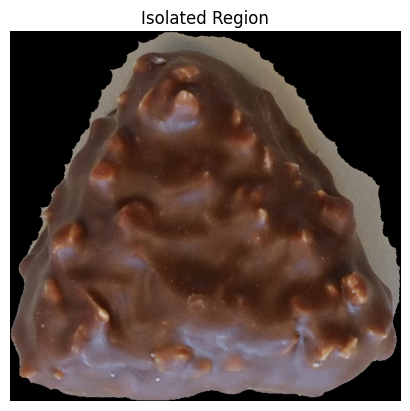

In [352]:
from skimage.measure import label, regionprops

# Label connected components in the binary mask
labeled_mask = label(mask)

# Get properties of each connected component
regions = regionprops(labeled_mask)

# Select the largest connected component (or any specific one)
if regions:
    # Example: Select the largest region by area
    largest_region = max(regions, key=lambda x: x.area)
    minr, minc, maxr, maxc = largest_region.bbox  # Bounding box of the region

    # Create a mask for the largest region
    isolated_mask = labeled_mask == largest_region.label

    # Apply the mask to the original image
    isolated_img = np.zeros_like(img_ref)
    isolated_img[isolated_mask] = img_ref[isolated_mask]

    # Crop the isolated region
    cropped_isolated_img = isolated_img[minr-1:maxr+1, minc-1:maxc+1]

    # Display the isolated region
    plt.figure()
    plt.imshow(cropped_isolated_img)
    plt.title("Isolated Region")
    plt.axis("off")
    plt.show()

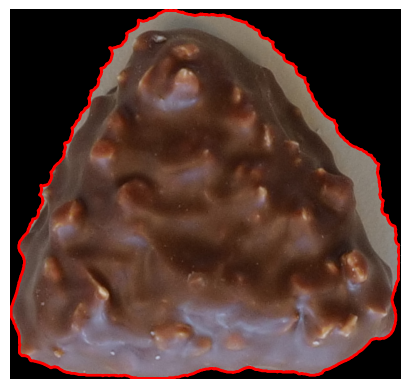

In [353]:
plt.figure()
img = cropped_isolated_img
img = np.array(img)
img = np.mean(img, axis=2)
binary = img > 0 
contours = find_contours(binary, level=0.5)
contour_single = []
if contours:
    contour = np.fliplr(max(contours, key=lambda x: x.shape[0]))
    contour_single.append(contour)
    plt.imshow(cropped_isolated_img, cmap='gray')
    plt.axis('off')
    plt.plot(contour[:, 0], contour[:, 1], linewidth=2, color='red')  # use [:, 0] and [:, 1]


In [354]:
contour_single = linear_interpolation(contour_single, n_samples = 150)
descriptor = normalize_descriptors(translation_invariant(rotation_invariant(compute_descriptor_padding(contour_single))))
descriptor.shape

(1, 11)

Find the most similar shape Fourier descriptor:

In [355]:
print(descriptor)

[[0.         1.         0.56703134 0.38030847 0.33097957 0.29206851
  0.29861901 0.31668049 0.39234191 0.53778036 1.01976723]]


In [356]:
print(mean_descriptors)

{np.int64(0): array([0.        , 1.        , 0.56727286, 0.38172061, 0.32951347,
       0.30595615, 0.29700072, 0.3107289 , 0.37801215, 0.58443181,
       0.94637689]), np.int64(1): array([0.        , 1.        , 0.49846308, 0.35593838, 0.28907166,
       0.26547962, 0.28295227, 0.29872678, 0.35418562, 0.49338809,
       0.90667292]), np.int64(2): array([0.        , 1.        , 0.49040555, 0.34209407, 0.27416441,
       0.25568969, 0.24767342, 0.26364481, 0.31779047, 0.44347669,
       0.70762955]), np.int64(3): array([0.        , 1.        , 0.51385386, 0.34810581, 0.29855194,
       0.25750003, 0.29434031, 0.30026203, 0.364087  , 0.47646893,
       0.91265456])}


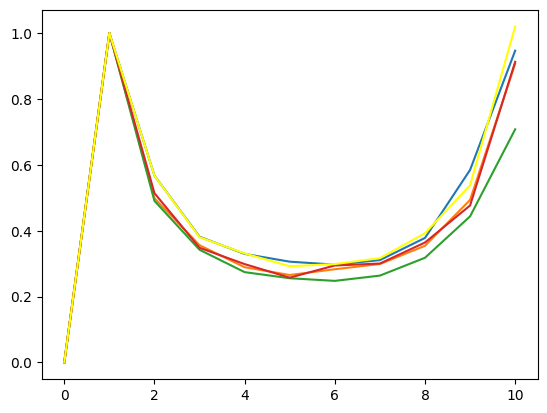

In [357]:
plt.figure()
for d in mean_descriptors:
    plt.plot(mean_descriptors[d])

plt.plot(descriptor[0], color='yellow')

In [358]:
def find_closest_shape(descriptor, mean_descriptors):
    """
    Find the closest shape by comparing the descriptor to the mean descriptors.

    Args:
    -----
    descriptor: np.ndarray
        The Fourier descriptor of the chocolate to classify.
    mean_descriptors: dict
        A dictionary where keys are shape labels and values are mean descriptors.

    Returns:
    --------
    closest_shape: int
        The label of the closest shape.
    """
    closest_shape = None
    min_distance = float('inf')

    for shape_label, mean_descriptor in mean_descriptors.items():
        # Compute the Euclidean distance
        distance = np.linalg.norm(descriptor - mean_descriptor)
        print(distance)
        if distance < min_distance:
            min_distance = distance
            closest_shape = shape_label

    return closest_shape

# Example usage
# `descriptor` is the Fourier descriptor of the chocolate to classify
# `mean_descriptors` is the dictionary of mean descriptors for each shape
closest_shape = find_closest_shape(descriptor, mean_descriptors)
print(f"The closest shape is: {closest_shape}")

0.089459209942312
0.15666343110451522
0.3594057604712591
0.14976587126740504
The closest shape is: 0


### Test with 1 training image ###

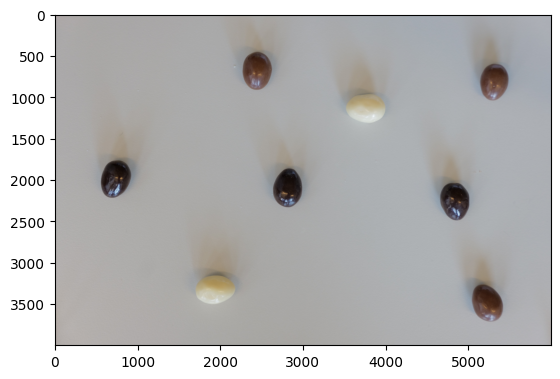

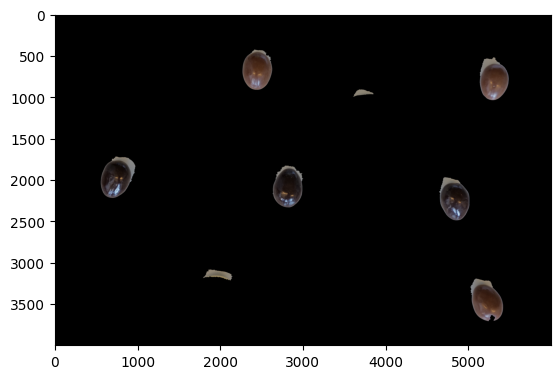

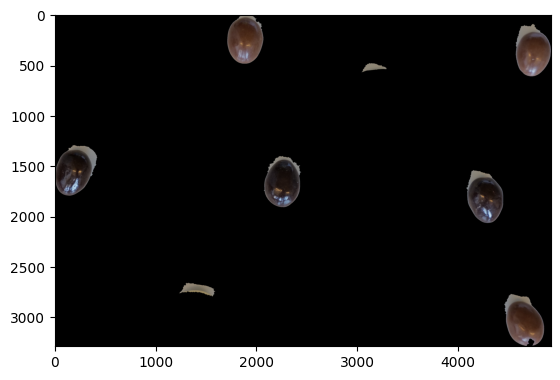

In [ ]:
path_ref = '../project/dataset_project_iapr2025/train'

jpg_files = [f for f in os.listdir(path_ref)]
n_images = len(jpg_files)

for i in range(len(jpg_files)):
    
    if i == 1:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = mpimg.imread(img_path)
        plt.imshow(img)
        
        img = Image.open(img_path).convert('L')
        img = np.array(img)
        img = img < 135

        footprint = disk(10)
        img = closing(img, footprint)
        img = remove_small_holes(img, 10000)
        mask = img.copy() #np.all(img > 1, axis=2)
        img_ref = mpimg.imread(img_path)
        masked_img = np.zeros_like(img_ref)
        masked_img[mask] = img_ref[mask]
        plt.figure()
        plt.imshow(masked_img)

        # Crop it
        coords = np.argwhere(mask) 
        y0, x0 = coords.min(axis=0)
        y1, x1 = coords.max(axis=0) + 1  # +1 because slicing is exclusive
        cropped_img = masked_img[y0:y1, x0:x1]
        plt.figure()
        plt.imshow(cropped_img)



### Edge detection ###

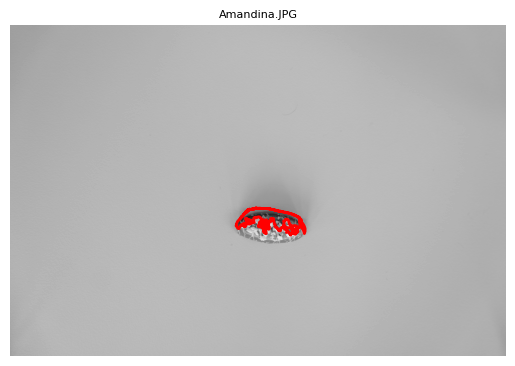

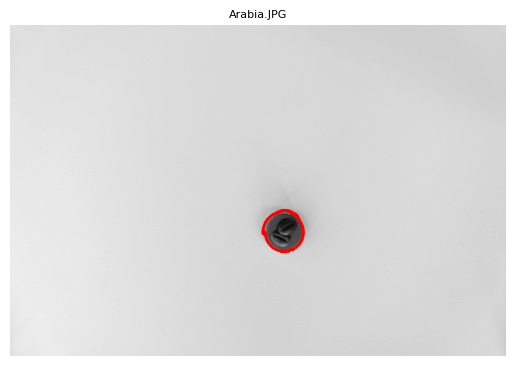

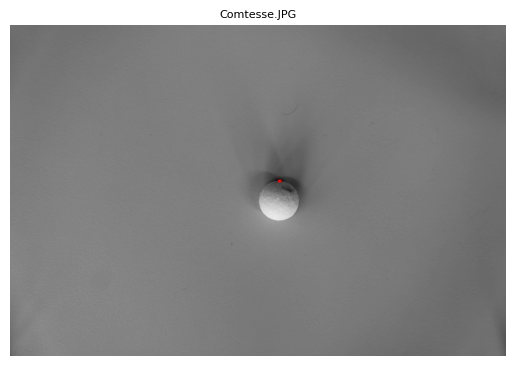

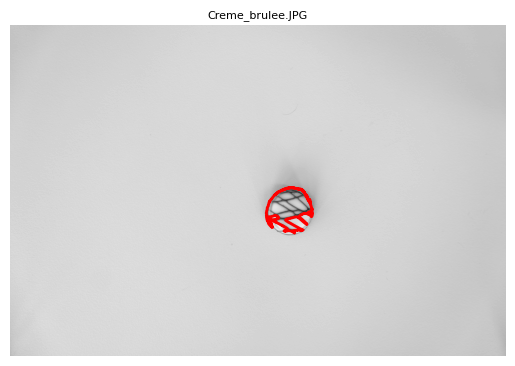

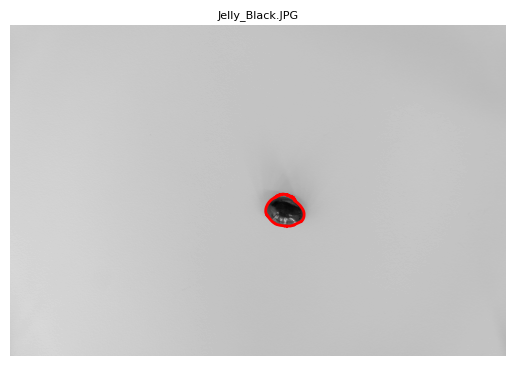

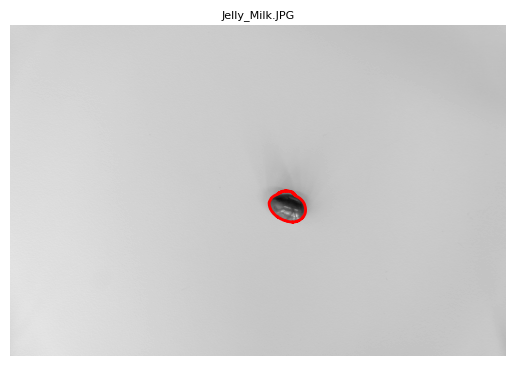

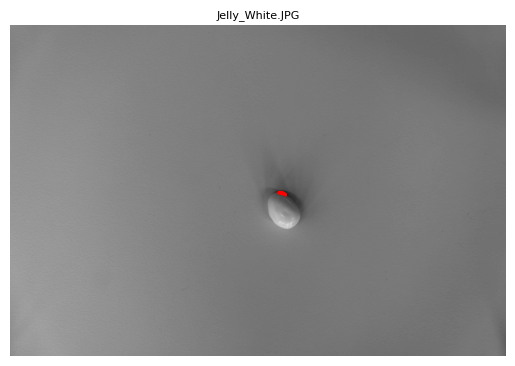

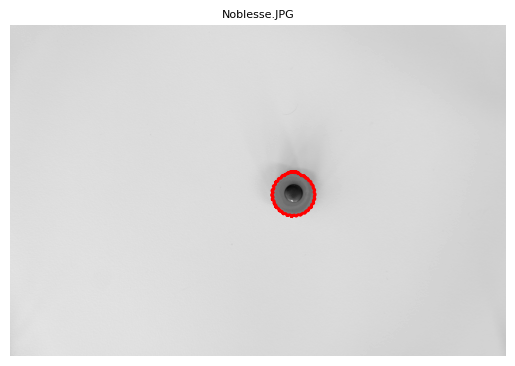

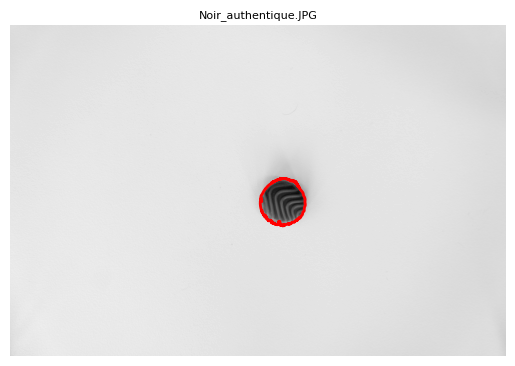

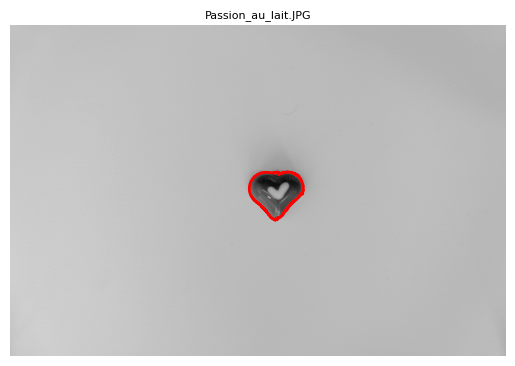

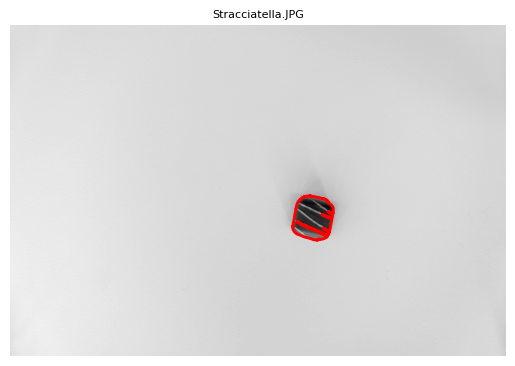

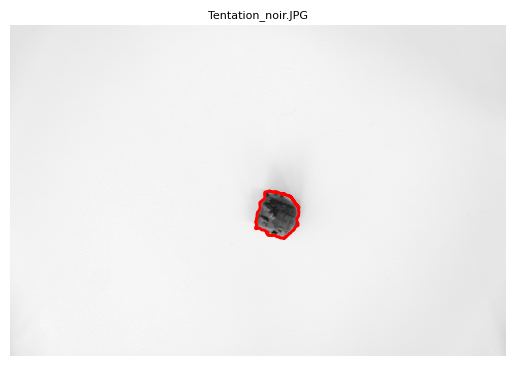

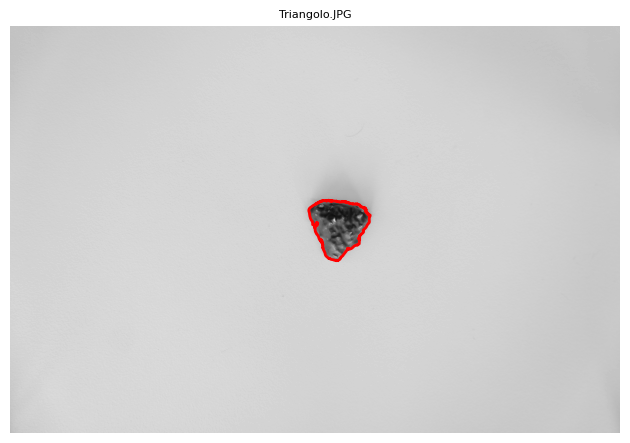

In [ ]:
for i, ax in enumerate(axes):
    if i < n_images:
        img_path = os.path.join(path_ref, jpg_files[i])
        img = Image.open(img_path).convert('L')
        img_np = np.array(img)

        binary = img_np < 135 
        contours = find_contours(binary, level=0.5)

        if contours:
            contour = np.fliplr(max(contours, key=lambda x: x.shape[0]))

            fig, ax = plt.subplots()
            ax.imshow(img_np, cmap='gray')
            ax.set_title(jpg_files[i], fontsize=8)
            ax.axis('off')
            ax.plot(contour[:, 0], contour[:, 1], linewidth=2, color='red')  # use [:, 0] and [:, 1]
    else:
        ax.axis('off')  # Hide empty subplots

plt.tight_layout()
plt.show()

c:\Installation\Anaconda\envs\iapr_project\lib\site-packages\skimage\measure\_find_contours.py:144: RuntimeWarning: overflow encountered in scalar add
  level = (np.nanmin(image) + np.nanmax(image)) / 2.0


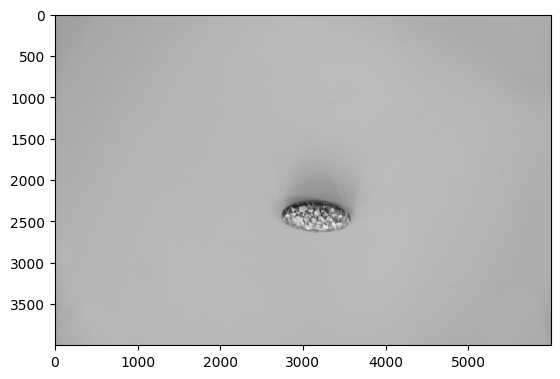

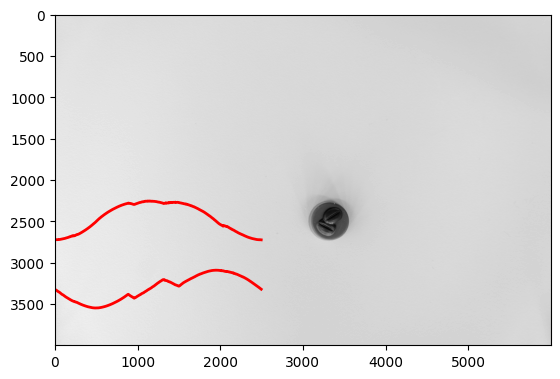

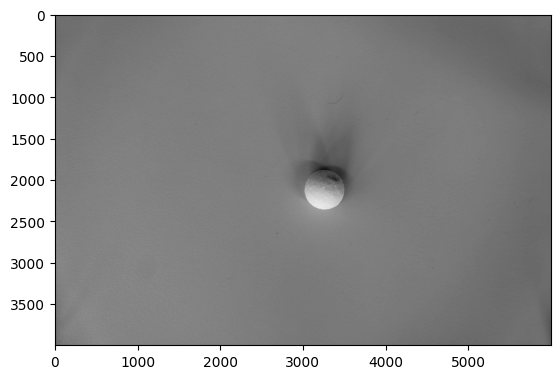

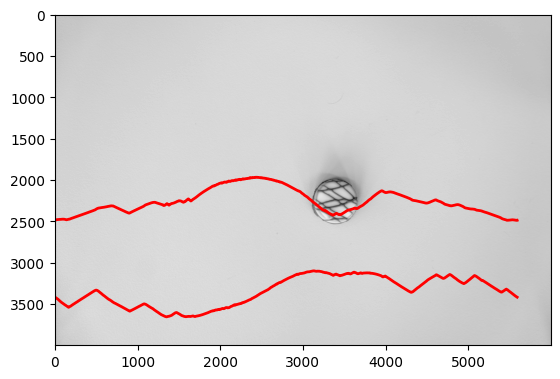

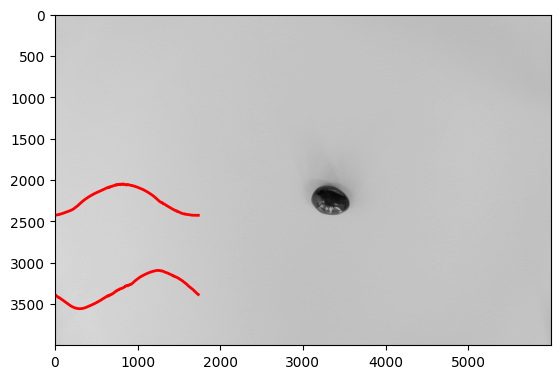

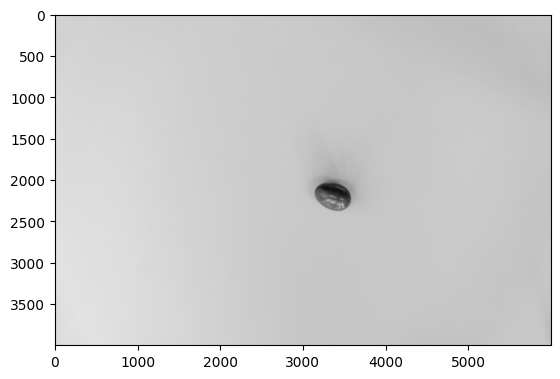

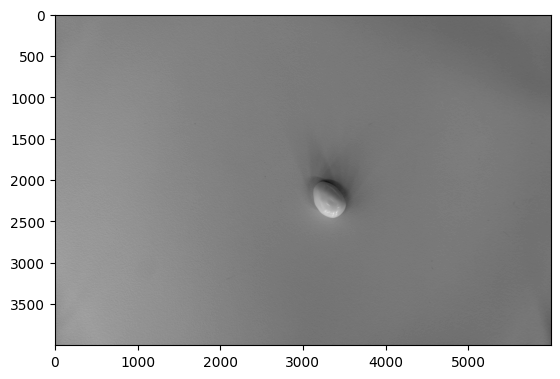

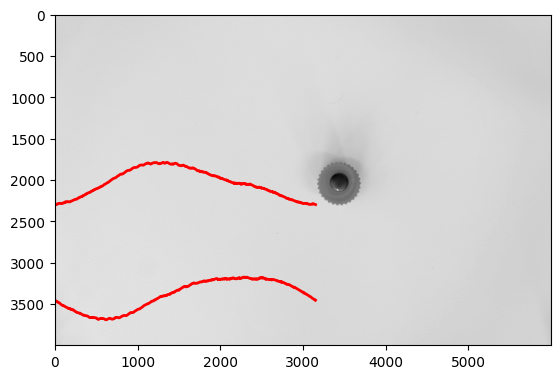

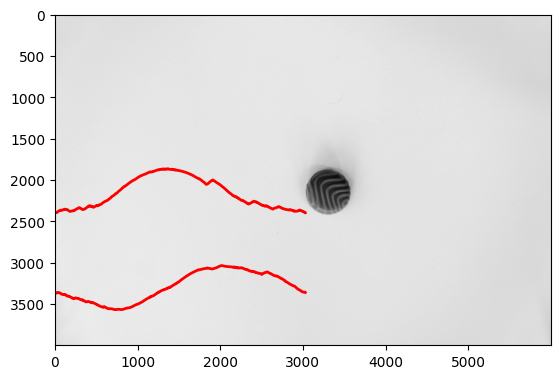

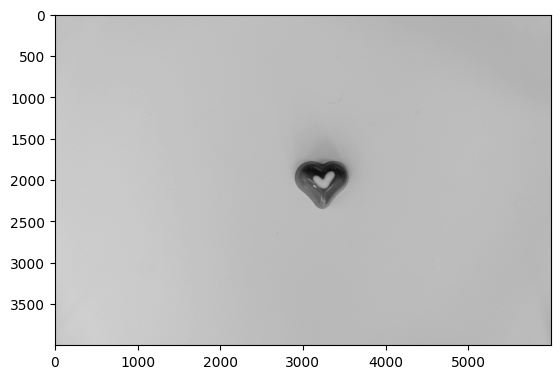

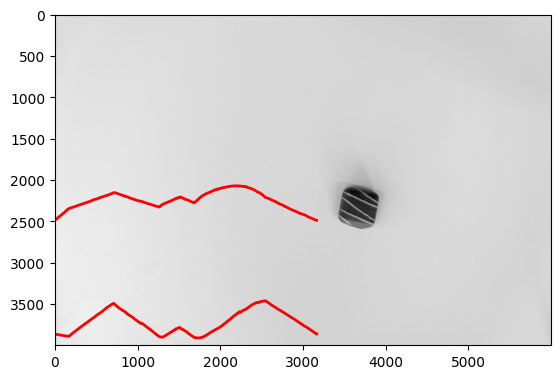

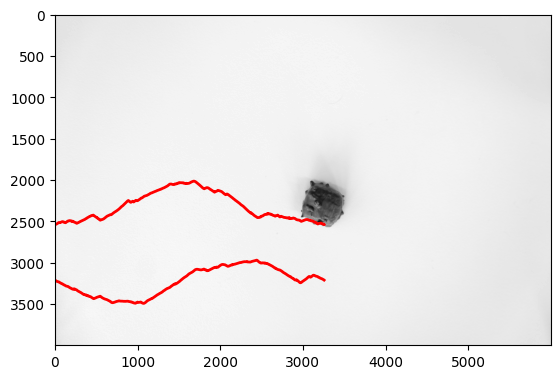

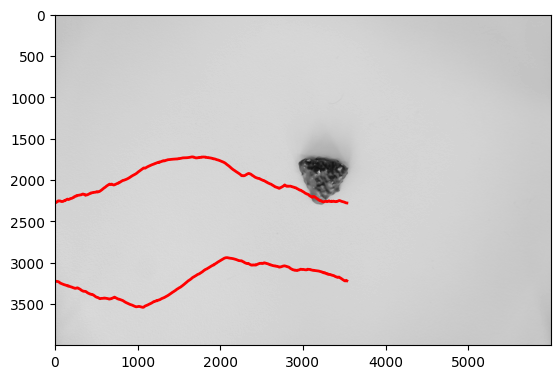

In [ ]:
contours = [np.array([[0, 0], [1, 1]]) for i in range(n_images)]

for i in range(n_images):
    img_path = os.path.join(path_ref, jpg_files[i])
    img = Image.open(img_path).convert('L')

    fig, ax = plt.subplots()
    ax.imshow(np.array(img), cmap='gray')

    contour = find_contours(np.array(img))
    if contour != []:
        longest = max(contour, key=lambda x:x.shape[0])
        contours[i] = np.fliplr(longest) 
        ax.plot(contours[i], linewidth=2, color='red')